In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import muon as mu
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

sc.settings.n_jobs = 8
sc.settings.verbosity = 0
sc.settings.set_figure_params(dpi=100, facecolor='white', figsize=(5,5), frameon=False)

In [2]:
adata_splatter = sc.read_h5ad('../data/splatter.h5ad')

In [3]:
adata_splatter.obsm['X_umap'] = adata_splatter.obsm['X_UMAP'].copy()

In [4]:
adata_splatter.var['ensembl_ids'] = adata_splatter.var_names.copy()
adata_splatter.var_names = adata_splatter.var['Gene'].astype(str).copy()
adata_splatter.var_names_make_unique()

/Users/pax/miniconda3/envs/LS_env/lib/python3.10/site-packages/anndata/utils.py:241: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD116-1', 'SNORD116-2', 'SNORD116-3', 'SNORD116-4', 'SNORD116-5']
  warnings.warn(


In [5]:
adata_splatter.layers['counts'] = adata_splatter.X.copy()
sc.pp.normalize_total(adata_splatter, target_sum=None)
sc.pp.log1p(adata_splatter)
adata_splatter.layers['log_norm'] = adata_splatter.X.copy()

In [6]:
sc_adata = sc.read_h5ad('/Users/pax/Library/CloudStorage/OneDrive-KarolinskaInstitutet/PhD/Ray_2022/Notebook/Results_h5ad/02_scRNA_hDRG_ready.h5ad')
sc_adata_raw = sc.read_h5ad('/Users/pax/Library/CloudStorage/OneDrive-KarolinskaInstitutet/PhD/Ray_2022/Notebook/hDRG_scRNA_raw.h5ad')

In [7]:
obs_keep = sc_adata_raw.obs_names.intersection(sc_adata.obs_names)

sc_adata = sc_adata[obs_keep].copy()
sc_adata = sc_adata.raw.to_adata()
sc_adata_raw = sc_adata_raw[obs_keep].copy()

In [8]:
sc_adata.var_names = sc_adata.var_names.str.upper()
sc_adata_raw.var_names = sc_adata_raw.var_names.str.upper()

var_keep = sc_adata_raw.var_names.intersection(sc_adata.var_names)

sc_adata = sc_adata[:,var_keep].copy()
sc_adata_raw = sc_adata_raw[:,var_keep].copy()

In [9]:
sc_adata.X = sc_adata_raw.layers['counts'].copy()
del sc_adata_raw

In [10]:
sc_adata.layers['counts'] = sc_adata.X.copy()
sc.pp.normalize_total(sc_adata, target_sum=None)
sc.pp.log1p(sc_adata)
sc_adata.layers['log_norm'] = sc_adata.X.copy()

In [11]:
adata_bf = sc.read_h5ad('../data/BF_neuron.h5ad')

/Users/pax/miniconda3/envs/LS_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1900: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [12]:
adata_bf.var_names_make_unique()

In [13]:
adata_bf = adata_bf[adata_bf.obs.supercluster_term == 'Splatter'].copy()

In [14]:
adata_bf.X = adata_bf.layers['counts'].copy()
sc.pp.normalize_total(adata_bf, target_sum=None)
sc.pp.log1p(adata_bf)
adata_bf.layers['log_norm'] = adata_bf.X.copy()

In [15]:
var_keep = sc_adata.var_names.intersection(adata_bf.var_names)

In [16]:
sc_adata = sc_adata[:,var_keep].copy()
adata_splatter = adata_splatter[:,var_keep].copy()
adata_bf = adata_bf[:,var_keep].copy()

In [17]:
sc.pp.scale(adata_splatter, max_value=10)
sc.pp.scale(adata_bf, max_value=10)
sc.pp.scale(sc_adata, max_value=10)

In [18]:
adatas = [adata_splatter[adata_splatter.obs.tissue == i] for i in adata_splatter.obs.tissue.cat.categories]

In [19]:
tissues = adata_splatter.obs.tissue.cat.categories.to_list()
tissues.append('septal nuclei')
tissues.append('DRG')

In [20]:
adatas.append(adata_bf)
adatas.append(sc_adata)

In [21]:
# Create a list to hold correlation matrices and p-value matrices for each pair of tissues
correlation_matrices = []
p_value_matrices = []

from scipy import stats
# Assuming you have data in a list of dataframes 'tissue_data'
for i in range(len(adatas)):
    corr_row = []
    p_value_row = []
    for j in range(len(adatas)):
        corr, p_value = stats.spearmanr(adatas[i].X.sum(axis=0), adatas[j].X.sum(axis=0))
        corr_row.append(corr)
        p_value_row.append(p_value)
    correlation_matrices.append(corr_row)
    p_value_matrices.append(p_value_row)

In [22]:
corre_tab = pd.DataFrame(np.array(correlation_matrices), columns=tissues, index=tissues)

In [23]:
corre_tab.to_csv('./Results_table/03_Tissue_corr_tab.csv')

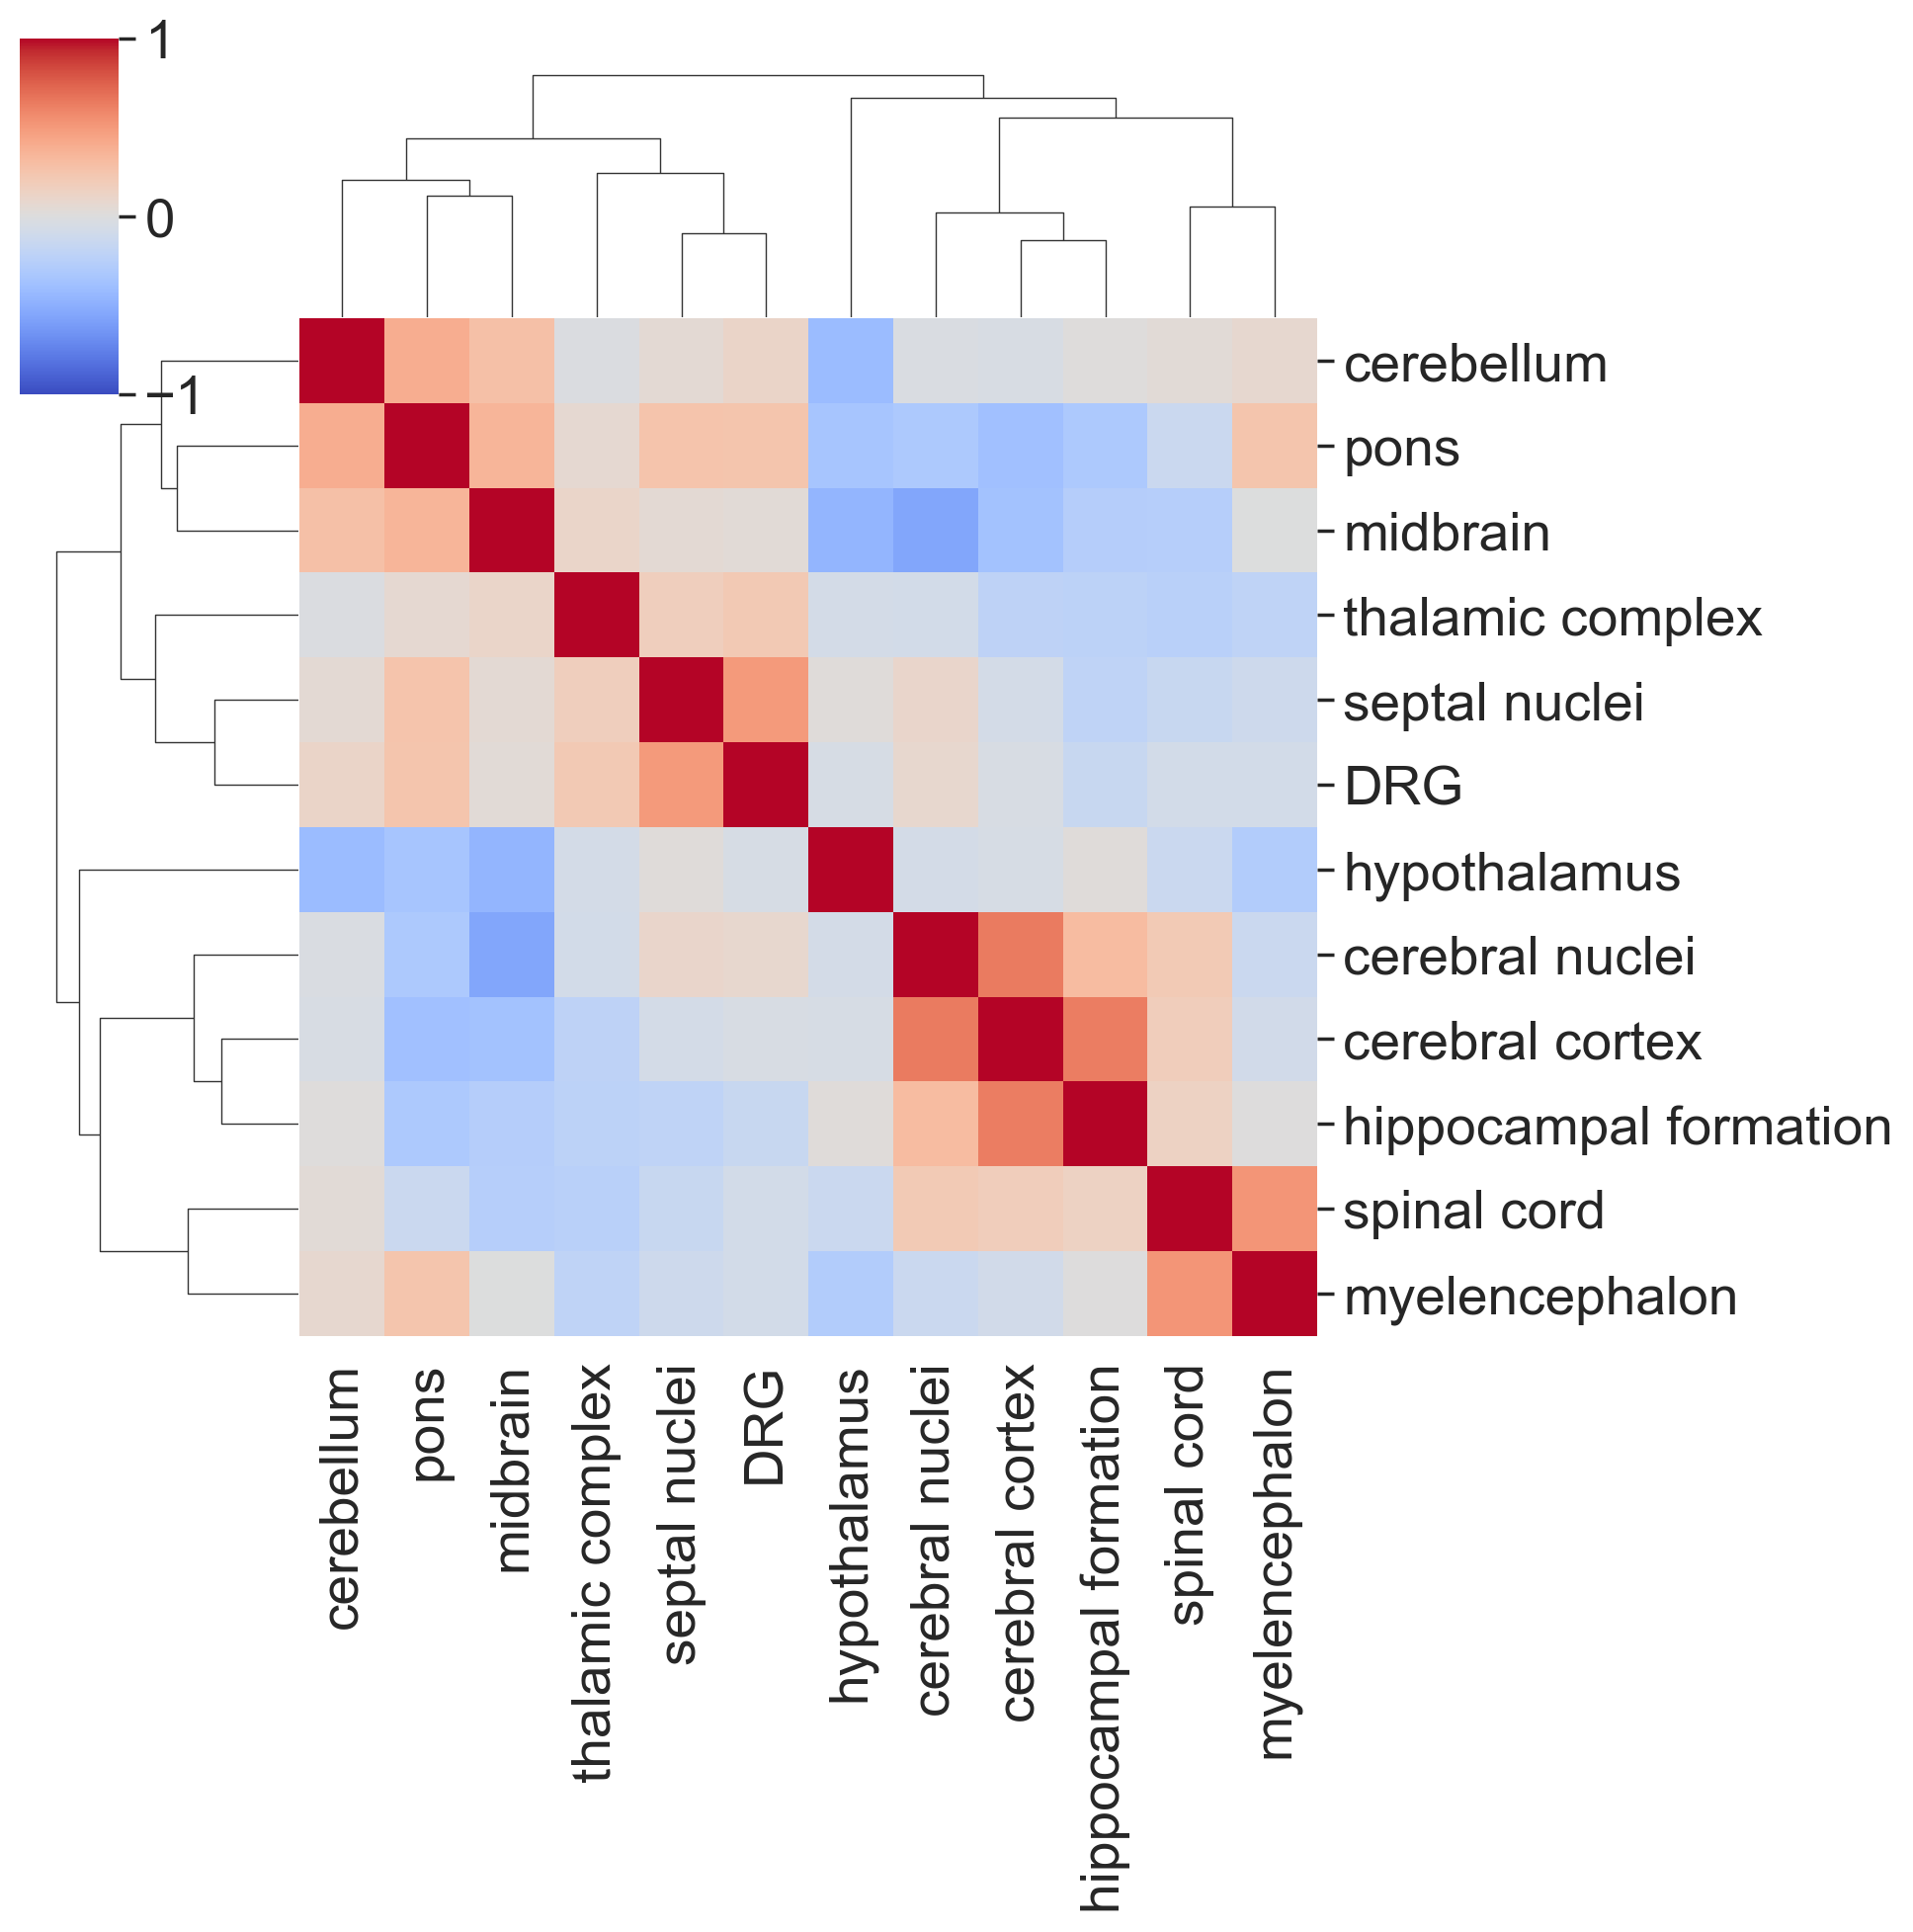

In [62]:
sns.set_style("whitegrid", {'axes.grid' : False})
sns.set(font_scale=1.8)
sns.clustermap(corre_tab, cmap='coolwarm', annot=False, cbar_kws={'shrink': 0.6}, vmin=-1, vmax=1)

In [25]:
bulk = [adata.X.sum(axis=0) for adata in adatas]

In [26]:
bulk = pd.DataFrame(bulk, index=tissues)

In [27]:
bulk = sc.AnnData(bulk)

/Users/pax/miniconda3/envs/LS_env/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [28]:
bulk.obs['Tissue'] = bulk.obs_names.astype(str).copy()

In [29]:
bulk.obs['Tissue'] = bulk.obs['Tissue'].astype('category')

In [35]:
bulk.obs['Tissue'] = bulk.obs['Tissue'].cat.reorder_categories(['DRG', 'septal nuclei', 'cerebellum', 'cerebral cortex', 'cerebral nuclei',
                                                                'hippocampal formation', 'hypothalamus', 'midbrain', 'myelencephalon',
                                                                'pons', 'spinal cord', 'thalamic complex'])

/Users/pax/miniconda3/envs/LS_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/pax/miniconda3/envs/LS_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/pax/miniconda3/envs/LS_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


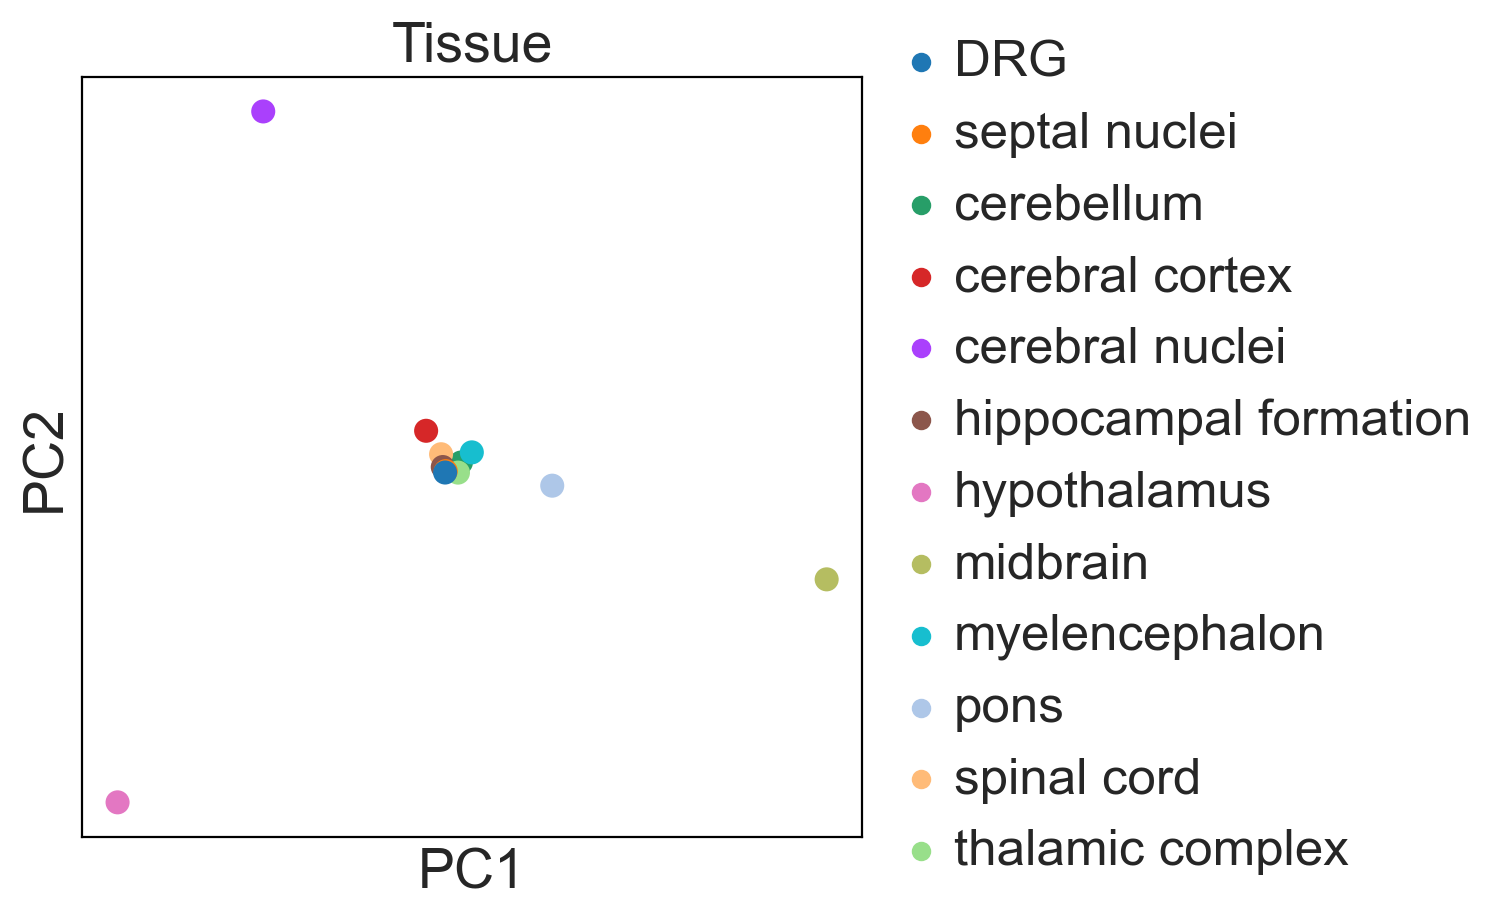

/Users/pax/miniconda3/envs/LS_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1169: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if groups and is_categorical_dtype(values):
/Users/pax/miniconda3/envs/LS_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/pax/miniconda3/envs/LS_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/pax/miniconda3

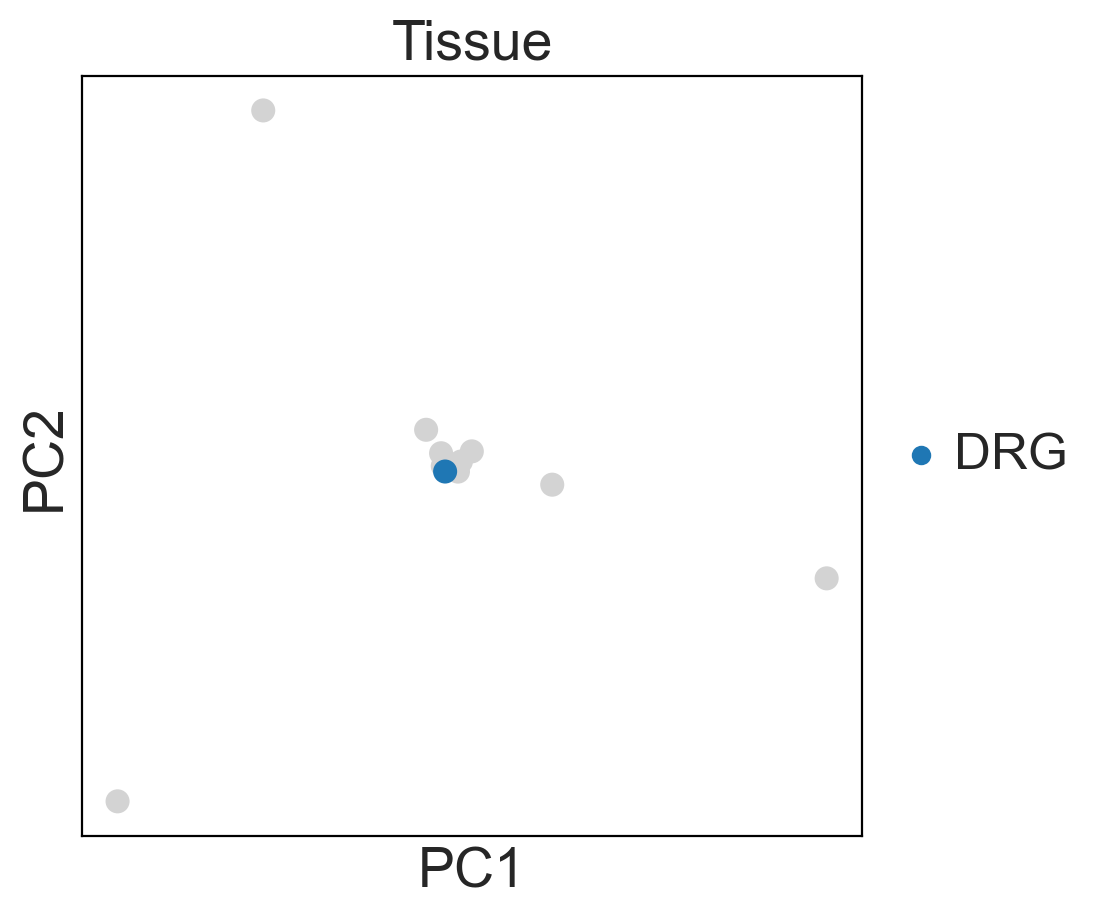

/Users/pax/miniconda3/envs/LS_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1169: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if groups and is_categorical_dtype(values):
/Users/pax/miniconda3/envs/LS_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/pax/miniconda3/envs/LS_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/pax/miniconda3

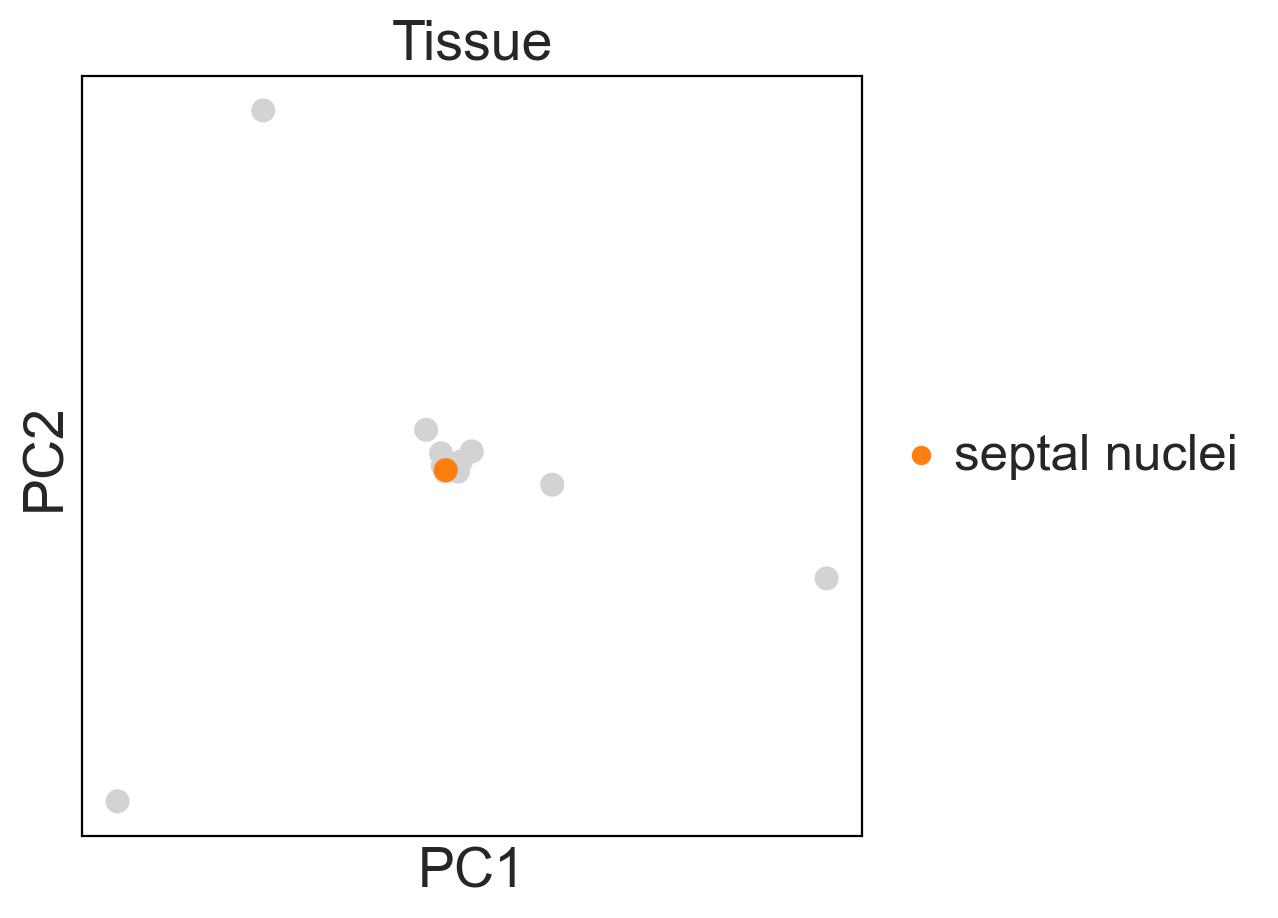

In [61]:
sc.pp.pca(bulk)
sc.settings.set_figure_params(dpi=100, facecolor='white', figsize=(5,5), frameon=False, fontsize=20)
sc.pl.pca(bulk, color='Tissue', s=300, frameon=True)
sc.pl.pca(bulk, color='Tissue', s=300, groups=['DRG'], na_in_legend=False, frameon=True)
sc.pl.pca(bulk, color='Tissue', s=300, groups=['septal nuclei'], na_in_legend=False, frameon=True)